**Table of contents**<a id='toc0_'></a>    
- 1. [Giới thiệu về hướng triển khai](#toc1_)    
- 2. [Hàm tiện ích](#toc2_)    
  - 2.1. [Hàm pipelines xử lý dữ liệu](#toc2_1_)    
    - 2.1.1. [Thao tác file](#toc2_1_1_)    
    - 2.1.2. [Tạo đặc trưng](#toc2_1_2_)    
  - 2.2. [Một số utils khác](#toc2_2_)    
  - 2.3. [Data Augmentation](#toc2_3_)    
- 3. [Xử lý data](#toc3_)    
  - 3.1. [Tạo features](#toc3_1_)    
  - 3.2. [Chia train-test](#toc3_2_)    
  - 3.3. [Điều chỉnh nhãn](#toc3_3_)    
- 4. [Huấn luyện mô hình](#toc4_)    
  - 4.1. [Setup hyper-parameters](#toc4_1_)    
  - 4.2. [Huấn luyện (fit)](#toc4_2_)    
  - 4.3. [Dự đoán trên tập test](#toc4_3_)    
  - 4.4. [Đánh giá](#toc4_4_)    
- 5. [Xuất](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Giới thiệu về hướng triển khai](#toc0_)

- Mục tiêu: tìm hiểu mô hình và xác lập kỳ vọng
  
- Mô hình sử dụng: <strong>LightGBM</strong>

- Quy trình thực hiện:

    - <strong>(✓) 0.</strong> Chuẩn bị dữ liệu (extinct Flux)
    - <strong>1.1 Features Engineering</strong>, cụ thể gồm:
        - <strong>(✓)</strong> Liên quan tới thống kê: mean, min-max, std, var, skewness, kurtosis, skewness
        - Liên quan tới vật lý: Abs_Flux = mean_flux * (1 + Z)
        - Một số đặc trưng khác muốn điều tra độ hiệu quả: weight, liên quan chuỗi thời gian
    - <strong>1.2</strong> Tối ưu việc sử dụng dataset - <strong>data augmentation</strong> (bằng cách tận dụng chia nhỏ split của 1 object để tăng số lượng input)
        - <strong>(✓)</strong> Theo hướng <strong>sampling</strong>: lấy mẫu ngẫu nhiên <strong>without replacement</strong> (no duplicate time-filter)
        - <strong>(✓)</strong> Theo hướng <strong>sliding-window</strong>: lấy một cụm dữ liệu split liên tiếp với nhau (theo trục thời gian)
    - <strong>(✓) 2</strong> Xử lý data
    - <strong>(✓) 3</strong> Xây dụng model
    - <strong>(✓) 4</strong> Thử nghiệm và đánh giá model (chưa tuning)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

from typing import Callable

pd.set_option('display.max_columns', None)

# Preparation for correct Flux (explain later)
# !pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Tải train_log
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

train_log = train_log.drop(['English Translation', 'target'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

## Tải test_log



In [2]:
train_log.head(3)


,object_id,Z,Z_err,EBV,SpecType,split
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01


# 2. <a id='toc2_'></a>[Hàm tiện ích](#toc0_)

In [3]:
sample_log = train_log[train_log['object_id'].isin(['amon_imloth_luin', 'cirion_ira_Ithil', 'cuin_haudh_cenedril']) ]
sample_log

,object_id,Z,Z_err,EBV,SpecType,split
12,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01
27,cirion_ira_Ithil,0.3325,0.0,0.023,SN Ia,split_01
30,cuin_haudh_cenedril,0.5366,0.0,0.013,AGN,split_01


## 2.1. <a id='toc2_1_'></a>[Hàm pipelines xử lý dữ liệu](#toc0_)


### 2.1.1. <a id='toc2_1_1_'></a>[Thao tác file](#toc0_)

- <strong>join_DataFrame (<i> df_log, df_split </i>)</strong> : liên kết log và split thành một bảng thống nhất

- <strong>jurassic_park (<i> row </i>)</strong> : hàm chỉnh sửa Flux (dust EBV extinction)

- <strong>process_and_combine_splits (<i> df_log, on_file, callback_func </i>)</strong> : đọc log và tự tìm đến file split tương ứng (dựa theo tên <i>on_file</i>)

- <strong>basic_process(<i> df_log, df_split </i>)</strong> : một đầu vào khả thi cho call_func của <strong><i>process_and_combine_splits</i></strong>, thực hiện join 2 DataFrame và khử Flux

In [4]:
def join_DataFrame (df_log:pd.DataFrame, df_split:pd.DataFrame) :
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
        ).dropna()

def jurassic_park(row):
    """Áp dụng hiệu chỉnh tuyệt chủng cho mỗi dòng."""
    # Lấy bước sóng hiệu dụng dựa trên Filter
    eff_wl = np.array([ WAVELENGTHS.get(row['Filter']) ])

    # Kiểm tra xem có Filter hợp lệ không
    if eff_wl is None:
        # Nếu filter không hợp lệ, trả về Flux gốc
        return row['Flux']

    # Tính A_lambda (mức độ tuyệt chủng ở bước sóng - lambda)
    A_lambda = fitzpatrick99(eff_wl, row['EBV'] * 3.1) # with 3.1 is Standard Milky Way value

    # Công thức hiệu chỉnh: Flux_hiệu_chỉnh = Flux_quan_sát * 10^(A_lambda / 2.5)
    flux_ext = row['Flux'] * 10**((A_lambda) / 2.5)

    return flux_ext

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame) :
    df_full_join = join_DataFrame(df_log, df_split)

    df_full_join['Flux'] = df_full_join.apply(jurassic_park, 
                                              axis=1, result_type='expand')
    
    
    return df_full_join.drop(['Z_err', 'split'], axis = 1)
    


sample_log_raw = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    basic_process
)
sample_log_raw

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter
0,amon_imloth_luin,0.7766,0.055,TDE,63899.3404,2.927328,0.255077,i
1,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.498455,0.101607,r
2,amon_imloth_luin,0.7766,0.055,TDE,63904.2198,3.827528,0.475724,z
3,amon_imloth_luin,0.7766,0.055,TDE,63916.4182,1.645513,0.206576,r
4,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.643693,0.150162,i
...,...,...,...,...,...,...,...,...
429,cuin_haudh_cenedril,0.5366,0.013,AGN,63116.7451,0.337371,0.484238,z
430,cuin_haudh_cenedril,0.5366,0.013,AGN,63132.7577,0.038233,1.404425,y
431,cuin_haudh_cenedril,0.5366,0.013,AGN,62897.9068,1.003183,1.320586,y
432,cuin_haudh_cenedril,0.5366,0.013,AGN,63159.4453,0.309557,0.132159,r


### 2.1.2. <a id='toc2_1_2_'></a>[Tạo đặc trưng](#toc0_)

- <strong>extract_features_for_single_object ( <i>object_id, df_object </i>)</strong> : extract features cho một sample. Toàn bộ input được coi là phạm vi dữ liệu gốc để khai thác, tất cả được trả ra dưới tên là đặc trưng của object_id.

In [5]:
from scipy.stats import skew, kurtosis

def extract_features_for_single_object(
    df_object: pd.DataFrame,
    object_id: str = None,
    columns_metadata = ['object_id', 'Z', 'SpecType'],
    columns_drop = ['Time (MJD)', 'EBV']
) -> pd.DataFrame:
    """
    Khai thác các đặc trưng thống kê (mean, min, max, std, var, peak, skew, kurt) 
    từ Flux và Flux_err, tính riêng biệt cho từng Filter.
    
    Lưu ý: DataFrameGroupBy có tên tương ứng object_id DUY NHẤT mà nó đại diện
    
    Danh sách cột tối thiểu phải có: object_id, [Z,	EBV, SpecType, Time (MJD),	Flux,	Flux_err,	Filter,]

    Args:
        df_object: DataFrame chỉ chứa dữ liệu của một object_id DUY NHẤT
                    

    Returns:
        DataFrame một hàng duy nhất chứa object_id, Z, SpecType và các đặc trưng khai thác.
    """

    # 1. Giữ lại các đặc trưng tĩnh (Metadata)
    df_object = df_object.drop(columns_drop, axis=1, errors='ignore')

    # Lấy thông tin metadata từ hàng đầu tiên vì chúng là hằng số cho object_id này
    metadata = {'object_id' : object_id, }
    metadata.update(df_object.iloc[0][columns_metadata].to_dict())
    metadata = pd.DataFrame([metadata])

    columns_stats = df_object.loc[:, ~df_object.columns.isin(columns_metadata + ['Filter'])].columns
    
    # 2. Định nghĩa các hàm thống kê
    def calculate_stats(series: pd.Series) -> pd.Series:
        series = pd.to_numeric(series, errors='coerce')
        """Tính các thống kê mean, min, max, std, var, peak, skew, kurtosis."""
        stats = {}
        
        # Thống kê cơ bản
        stats['mean'] = series.mean()
        stats['min'] = series.min()
        stats['max'] = series.max()
        stats['std'] = series.std()
        
        # Tính skewness và kurtosis từ scipy.stats
        stats['skewness'] = skew(series.dropna().values)
        stats['kurtosis'] = kurtosis(series.dropna().values)
        
        return pd.Series(stats)

    
    # 3. Nhóm theo Filter và tính toán đặc trưng
    grouped = df_object.groupby('Filter')
    
    # Áp dụng hàm thống kê cho cả Flux và Flux_err
    flux_stats = []
    for column in columns_stats :
        flux_stats.append(grouped[column].apply(calculate_stats)
                                        .unstack()
                                        .rename(columns=lambda stat: f'{column}_{stat}'))

    
    # 5. Kết hợp các đặc trưng cho từng Filter
    # pd.concat sẽ nối df_flux và df_flux_err theo trục 1 (cột)
    df_features = pd.concat(flux_stats, axis=1)
    
    # MultiIndex do Filter -> Chuyển Filter từ index thành phần của tên cột (sửa tên index)
    df_features = df_features.stack().to_frame()
    df_features.index = [f"{idx_Filter}_{idx_Column}" for idx_Filter, idx_Column in df_features.index]

    
    # 7. Nối metadata vào DataFrame cuối cùng
    df_final = pd.concat([metadata, df_features.T], axis=1)
    
    return df_final



# --- VÍ DỤ SỬ DỤNG ---
sample_log_extracted = []
for id, data in sample_log_raw.groupby('object_id') :
    temp = extract_features_for_single_object(data, id)
    sample_log_extracted.append(temp)
    
sample_log_extracted = pd.concat(sample_log_extracted)

sample_log_extracted


,object_id,Z,SpecType,g_Flux_mean,g_Flux_min,g_Flux_max,g_Flux_std,g_Flux_skewness,g_Flux_kurtosis,g_Flux_err_mean,g_Flux_err_min,g_Flux_err_max,g_Flux_err_std,g_Flux_err_skewness,g_Flux_err_kurtosis,i_Flux_mean,i_Flux_min,i_Flux_max,i_Flux_std,i_Flux_skewness,i_Flux_kurtosis,i_Flux_err_mean,i_Flux_err_min,i_Flux_err_max,i_Flux_err_std,i_Flux_err_skewness,i_Flux_err_kurtosis,r_Flux_mean,r_Flux_min,r_Flux_max,r_Flux_std,r_Flux_skewness,r_Flux_kurtosis,r_Flux_err_mean,r_Flux_err_min,r_Flux_err_max,r_Flux_err_std,r_Flux_err_skewness,r_Flux_err_kurtosis,u_Flux_mean,u_Flux_min,u_Flux_max,u_Flux_std,u_Flux_skewness,u_Flux_kurtosis,u_Flux_err_mean,u_Flux_err_min,u_Flux_err_max,u_Flux_err_std,u_Flux_err_skewness,u_Flux_err_kurtosis,y_Flux_mean,y_Flux_min,y_Flux_max,y_Flux_std,y_Flux_skewness,y_Flux_kurtosis,y_Flux_err_mean,y_Flux_err_min,y_Flux_err_max,y_Flux_err_std,y_Flux_err_skewness,y_Flux_err_kurtosis,z_Flux_mean,z_Flux_min,z_Flux_max,z_Flux_std,z_Flux_skewness,z_Flux_kurtosis,z_Flux_err_mean,z_Flux_err_min,z_Flux_err_max,z_Flux_err_std,z_Flux_err_skewness,z_Flux_err_kurtosis
0,amon_imloth_luin,0.7766,TDE,0.117817,-0.353279,0.937778,0.445634,0.920688,-0.381032,0.100243,0.089191,0.131092,0.014394,1.600877,1.236755,0.679377,-1.650098,3.791350,1.454136,0.843796,-0.250512,0.295821,0.150162,0.560407,0.134372,0.969371,-0.423800,0.505782,-0.748057,2.962307,0.884313,1.216836,0.591946,0.152529,0.101607,0.206576,0.031612,0.205585,-1.146544,-0.063364,-0.668667,0.213214,0.264293,-1.103160,0.388858,0.317772,0.256813,0.485282,0.067588,1.422465,1.427097,0.861575,-1.770718,4.426008,1.776593,0.711949,-0.599859,1.276271,0.734524,3.049068,0.593914,1.717961,2.344932,0.737509,-2.611428,4.346346,1.663140,0.740855,0.173180,0.578472,0.279658,1.873114,0.334830,2.892681,7.923715
0,cirion_ira_Ithil,0.3325,SN Ia,0.011813,-0.420473,0.449623,0.253647,0.094979,-0.645915,0.190478,0.093184,0.434047,0.082716,1.996507,4.033065,0.591125,-1.314032,5.186369,1.620982,1.586204,1.454939,0.341780,0.174128,0.709160,0.128269,1.109926,0.778692,0.368452,-0.688876,5.678118,1.313653,3.529234,11.255795,0.237831,0.117300,0.709408,0.113552,2.374728,6.884093,0.220205,-0.532150,1.429902,0.539082,0.604444,-0.199980,0.429143,0.256227,0.809246,0.150533,1.169672,0.819611,0.338794,-1.879675,3.595190,1.333626,0.455347,0.015009,1.412467,0.831285,2.209296,0.345928,0.748716,0.187107,0.304507,-1.168219,3.278926,1.111382,1.166159,0.669873,0.553279,0.302047,1.224593,0.223086,1.860197,3.290102
0,cuin_haudh_cenedril,0.5366,AGN,0.399174,-0.214327,1.068463,0.375915,0.178584,-0.816114,0.131714,0.066491,0.280995,0.067226,1.207324,0.079505,0.418636,-0.599195,1.711203,0.548138,0.216841,-0.733182,0.384388,0.181030,1.935983,0.335079,3.358951,11.341666,0.289775,-0.706266,1.296380,0.504389,0.344578,-0.657486,0.212740,0.098268,1.550139,0.217858,5.570338,31.648104,0.261375,-0.031519,0.696558,0.236671,0.543521,-0.856504,0.323520,0.255007,0.471172,0.066171,1.100485,0.187355,-0.209282,-3.754569,4.740503,1.614623,0.505653,2.127038,1.252423,0.652079,2.667796,0.501285,1.328100,1.424781,0.417539,-0.755543,2.726010,0.726779,1.000148,1.640416,0.556766,0.206663,1.735758,0.277058,2.590855,8.704051


## 2.2. <a id='toc2_2_'></a>[Một số utils khác](#toc0_)

In [6]:
from typing import List
from sklearn.metrics import confusion_matrix

def score_prediction(ground_truth:pd.Series, prediction:List, labels:List, focus_label:str) :
    df_compare = pd.DataFrame({
        'True label' : ground_truth.values,
        'Prediction' : prediction
    }, index=ground_truth.index)
    
    # Tính điểm từng label
    for label in labels :
        df_subset = df_compare[df_compare['True label'] == label]
        right = np.sum(df_subset['Prediction'] == label)
        total = len(df_subset)
        print(f'> {label} accuracy: {right}/{total}  ~ {(right/total * 100):.2f}%')

    # Tính F1-score
    cm = confusion_matrix(df_compare['True label'] == focus_label, 
                          df_compare['Prediction'] == focus_label, 
                          labels=[False, True])
    TN, FP, FN, TP = cm.ravel()
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    print(f'\t>>> F1-score: {F1_score:.2f}\n')

In [7]:
from typing import List, Union, Tuple

def plot_probability_distributions(
    proba: np.ndarray,
    label: pd.Series,
    class_names: List[str]
) -> None:
    """
    Vẽ ma trận 3x3 biểu đồ phân phối xác suất dự đoán (proba) của 
    mỗi lớp, được nhóm theo nhãn thực tế (label).

    Args:
        proba: Mảng 2D (N_samples, 3) chứa xác suất dự đoán (P_SN, P_AGN, P_TDE).
        label: Mảng 1D (N_samples) chứa nhãn thực tế (dạng chuỗi).
        class_names: Danh sách tên 3 lớp tương ứng với 3 cột xác suất.
    """
    N_CLASSES = len(class_names)

    # 1. Chuyển đổi thành DataFrame
    df = pd.DataFrame(proba, columns=[f'{name}' for name in class_names]).set_index(label.index)
    df['Prediction'] = pd.Series([class_names[i] for i in np.argmax(proba, axis=1)], index=label.index)
    df['True Label'] = label.values

    # 2. Thiết lập bố cục biểu đồ (3 hàng, 3 cột)
    fig, axes = plt.subplots(N_CLASSES, N_CLASSES, figsize=(24, 15), constrained_layout=True)


    # i: index hàng (tương ứng với nhãn thực tế)
    for i, true_label in enumerate(class_names):
        
        # Lọc dữ liệu theo nhãn thực tế hiện tại
        df_group = df[df['True Label'] == true_label]
        
        # j: index cột (tương ứng với xác suất của lớp j)
        for j, pred_class in enumerate(class_names):
            
            ax = axes[i, j]

            # Vẽ biểu đồ phân phối (KDE plot)
            # kde=True vẽ đường cong, hist=False không vẽ histogram
            sns.kdeplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            # sns.histplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            
            # Đặt tiêu đề cột
            if i == 0:
                ax.set_title(f'Phân phối P({pred_class})', fontsize=10)
            
            # Đặt tiêu đề hàng (nhãn thực tế)
            if j == 0:
                ax.set_ylabel(f'Nhãn Thực tế: {true_label}\n(Mật độ)', fontsize=12, weight='bold')

            # Đặt giới hạn trục x (từ 0 đến 1)
            ax.set_xlim(0, 1)
            ax.axvline(0.5, color='red', linestyle='--', linewidth=0.8) # Đường tham chiếu 0.5
            
            # Xóa nhãn trục y không cần thiết
            if j != 0:
                ax.set_ylabel('')
                
            # Xóa nhãn trục x ở các hàng trên cùng
            if i != (N_CLASSES - 1):
                ax.set_xlabel('')
            else:
                ax.set_xlabel(f'P({pred_class})', fontsize=10)


    plt.suptitle("Phân phối Xác suất Dự đoán theo Nhãn Thực tế (True Label)", fontsize=16, weight='bold', y=1.02)
    plt.show()
    return df

def plot_cluster_and_filter_distribution(list_of_clusters: List[pd.DataFrame], filter_list=['i', 'r', 'z', 'y', 'g', 'u']) -> None:
    """
    Vẽ 2 biểu đồ điểm (scatter plots) Flux vs Time (MJD) từ một list các DataFrame cluster.
    
    Biểu đồ 1: Màu sắc theo cột 'Filter'.
    Biểu đồ 2: Màu sắc theo ID của cluster (DataFrame gốc).

    Args:
        list_of_clusters: List chứa các DataFrame, mỗi DF là một cluster.
    """
    
    if not list_of_clusters:
        print("Danh sách các Cluster (DataFrame) rỗng, không thể vẽ biểu đồ.")
        return

    # --- 1. Tổng hợp dữ liệu và tạo cột phân loại ---
    
    all_data = []
    
    # Gán ID duy nhất cho mỗi cluster (DataFrame)
    for i, df_cluster in enumerate(list_of_clusters):
        df_temp = df_cluster[df_cluster['Filter'].isin(filter_list)].copy()
        # Tạo cột Cluster_ID dựa trên vị trí của DF trong List
        df_temp['Cluster_ID'] = f'Cluster_{i+1}' 
        all_data.append(df_temp)
        
    # Nối tất cả các DataFrame thành một DF lớn
    df_combined = pd.concat(all_data, ignore_index=True)

    # 2. Kiểm tra các cột bắt buộc
    required_cols = ['Time (MJD)', 'Flux', 'Filter']
    if not all(col in df_combined.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_combined.columns]
        print(f"Lỗi: DataFrame thiếu các cột bắt buộc: {missing}. Không thể vẽ biểu đồ.")
        return
        
    # --- 2. Tạo bố cục Biểu đồ (1 hàng, 2 cột) ---
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Đặt tiêu đề chung
    fig.suptitle(
        "So sánh Phân bố Dữ liệu theo Filter và Cluster", 
        fontsize=16, 
        fontweight='bold'
    )

    # --- BIỂU ĐỒ 1: Phân loại theo FILTER ---
    
    ax1 = axes[0]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Filter'
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Filter',  # Màu sắc theo 'Filter'
        ax=ax1,
        s=10,          # Kích thước điểm nhỏ
        alpha=0.7      # Độ trong suốt
    )
    ax1.set_title("Phân bố theo Filter", fontsize=14)
    ax1.set_xlabel("Time (MJD)", fontsize=12)
    ax1.set_ylabel("Flux", fontsize=12)
    ax1.legend(title='Filter', loc='best')

    # --- BIỂU ĐỒ 2: Phân loại theo CLUSTER_ID ---

    ax2 = axes[1]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Cluster_ID'
    # palette='tab10' hoặc 'hsv' nếu có nhiều hơn 10 clusters
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Cluster_ID',  # Màu sắc theo ID của cluster
        ax=ax2,
        s=10,
        alpha=0.7,
        # Nếu có quá nhiều clusters, hãy tắt legend để tránh lộn xộn
        legend='full' if len(list_of_clusters) <= 15 else False 
    )
    ax2.set_title("Phân bố theo Cluster ID", fontsize=14)
    ax2.set_xlabel("Time (MJD)", fontsize=12)
    ax2.set_ylabel("Flux", fontsize=12)
    if len(list_of_clusters) <= 15:
        ax2.legend(title='Cluster ID', loc='best', ncol=1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề chung hiển thị rõ
    plt.show()  

def plot_prediction_confusion_pie(df, true_label_col='True Label', pred_label_col='Prediction'):
    """
    Vẽ 3 biểu đồ tròn so sánh Prediction cho mỗi True Label.
    """
    # 1. Lấy danh sách các nhãn duy nhất (Giả sử có 3 loại: 0, 1, 2 hoặc TDE, SN, AGN)
    labels = sorted(df[true_label_col].unique())
    
    # 2. Cấu hình màu sắc cố định cho từng loại Prediction để dễ đối chiếu
    # Bạn có thể thay đổi màu sắc ở đây (ví dụ: xanh cho đúng, đỏ cho sai)
    colors = ['#ff9999','#66b3ff','#99ff99'] 
    color_map = {label: colors[i] for i, label in enumerate(labels)}

    # 3. Khởi tạo Figure với 1 hàng 3 cột
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Phân phối dự đoán cho từng nhãn thực tế (True Label)', fontsize=16, fontweight='bold')

    for i, true_val in enumerate(labels):
        # Lọc dữ liệu theo True Label hiện tại
        subset = df[df[true_label_col] == true_val]
        
        # Đếm số lượng từng loại Prediction
        counts = subset[pred_label_col].value_counts().reindex(labels, fill_value=0)
        
        # Vẽ biểu đồ tròn
        axes[i].pie(
            counts, 
            labels=counts.index, 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=[color_map[lbl] for lbl in counts.index],
            explode=[0.05 if lbl == true_val else 0 for lbl in counts.index] # Đẩy phần đúng ra một chút
        )
        axes[i].set_title(f'True Label: {true_val}', fontsize=14, color='darkblue')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 2.3. <a id='toc2_3_'></a>[Data Augmentation](#toc0_)

AGN


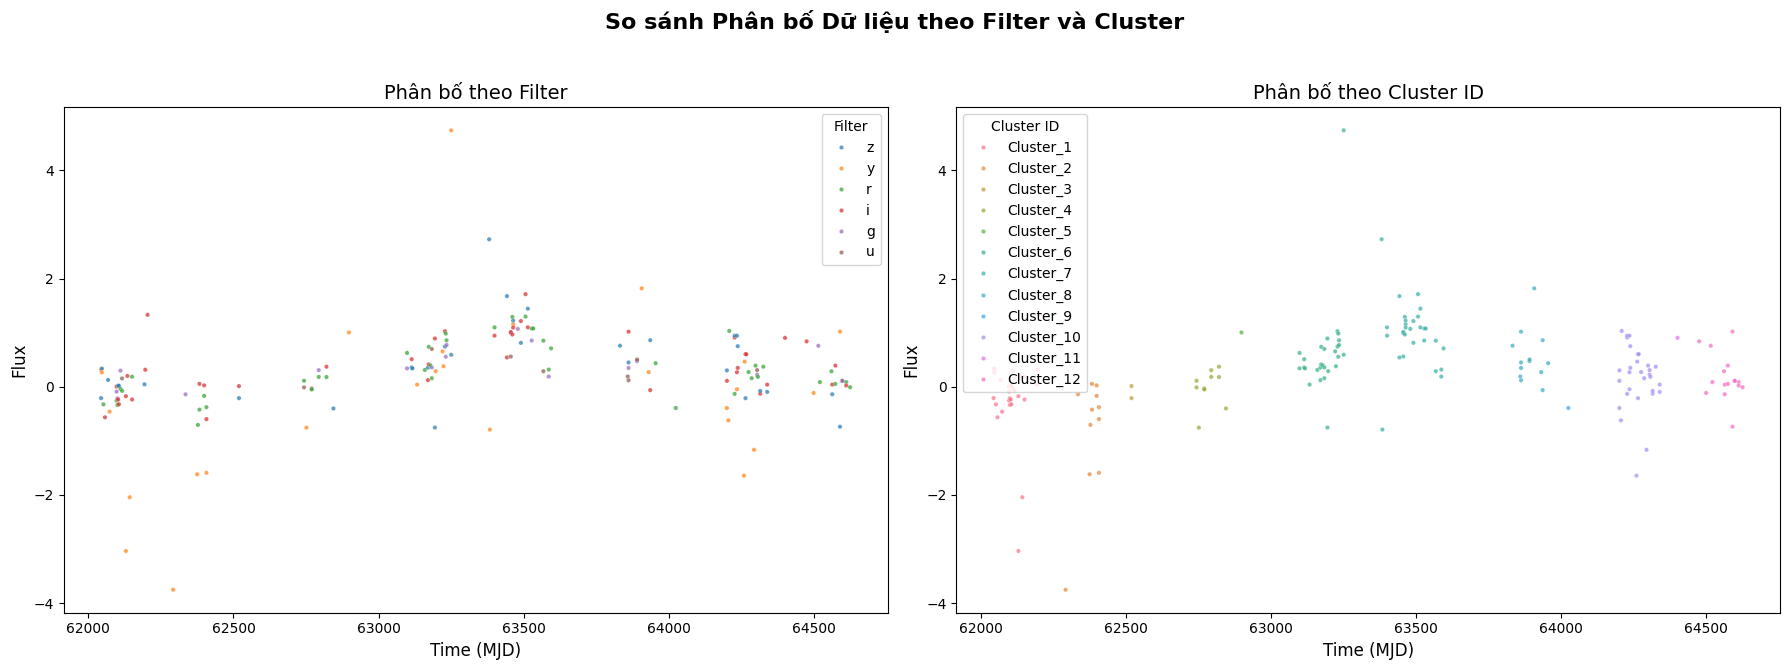

SN Ia


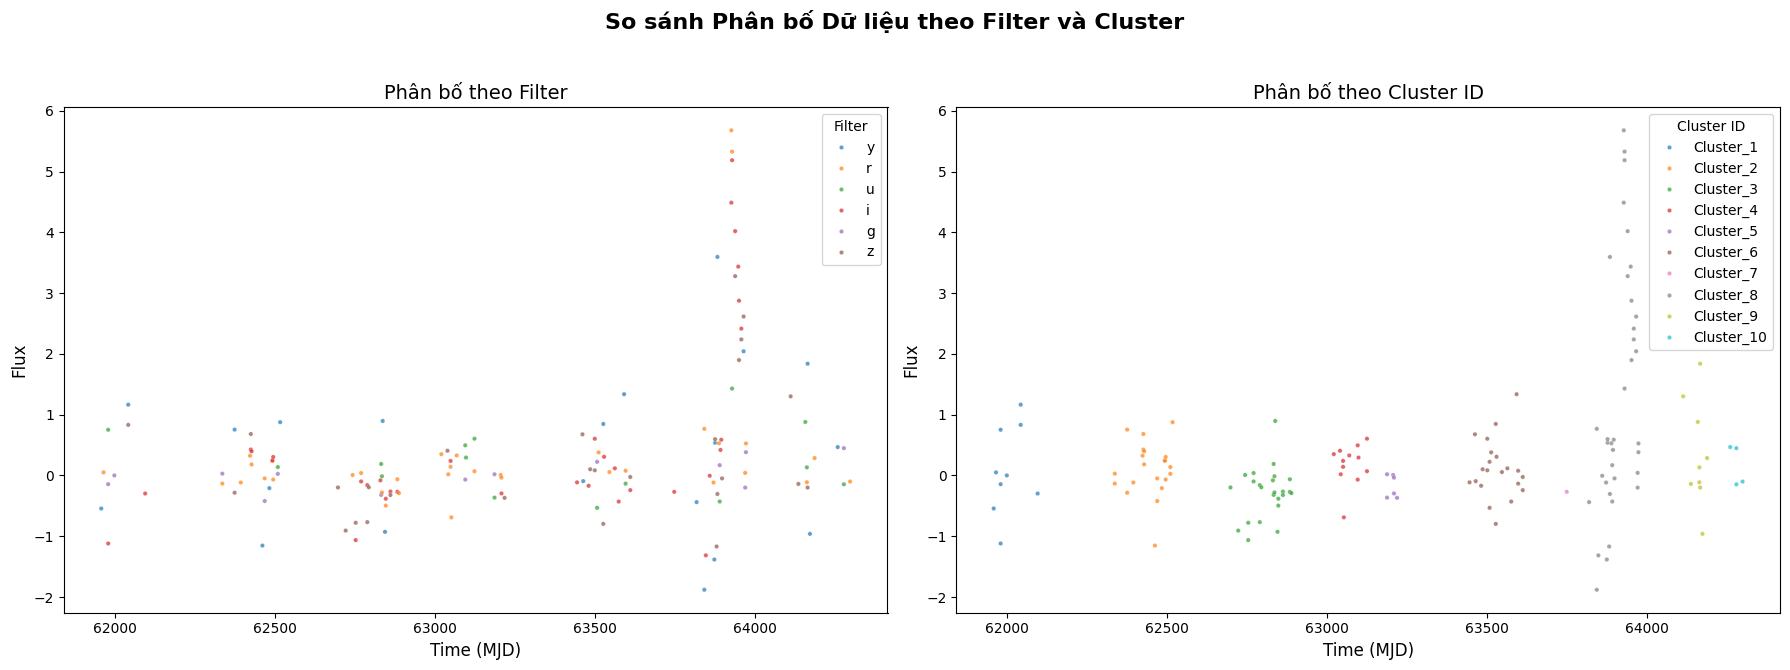

TDE


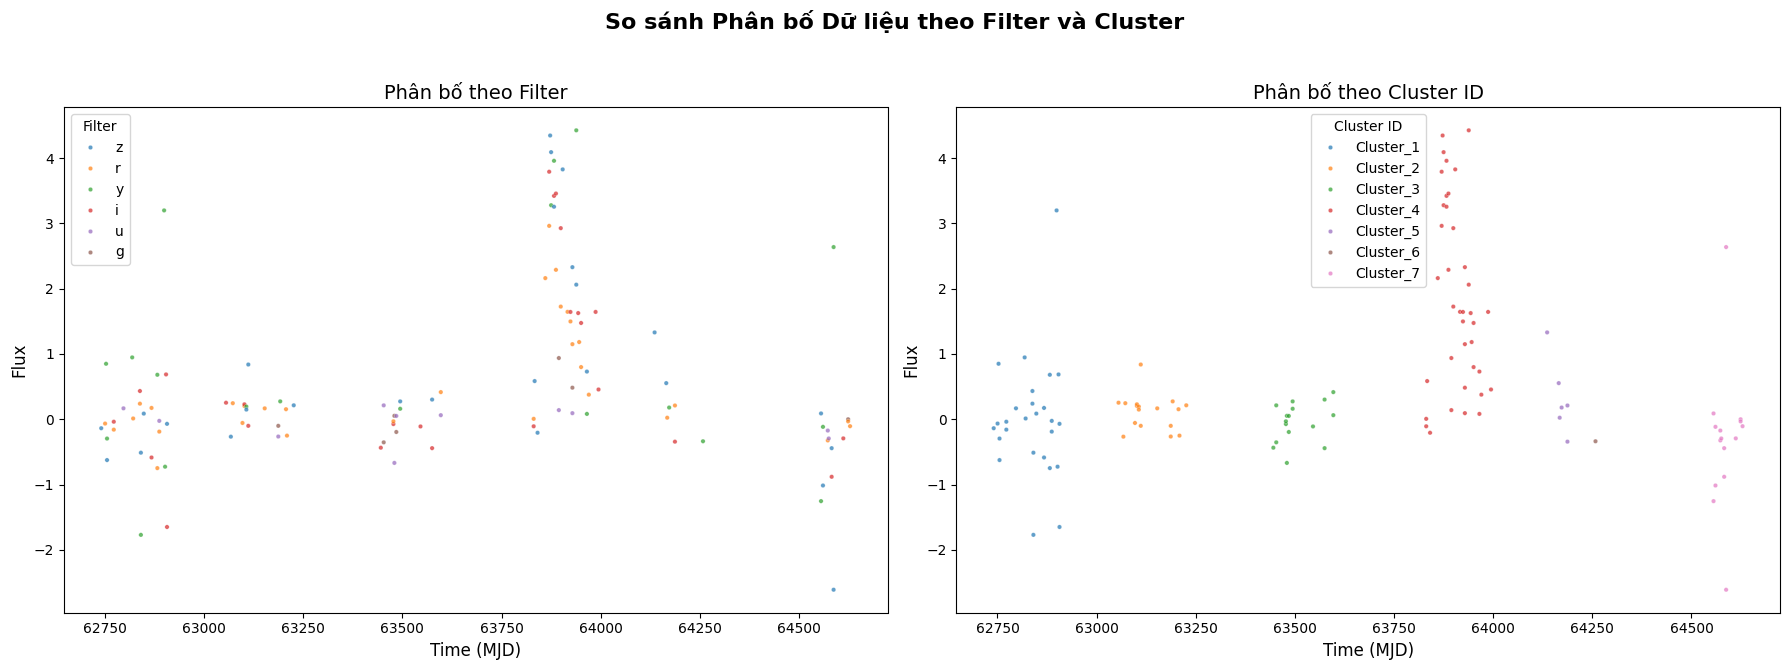

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter
0,amon_imloth_luin,0.7766,0.055,TDE,62740.4910,-0.137194,0.279658,z
1,amon_imloth_luin,0.7766,0.055,TDE,62750.2497,-0.066016,0.153388,r
2,amon_imloth_luin,0.7766,0.055,TDE,62752.6894,0.849852,0.889385,y
3,amon_imloth_luin,0.7766,0.055,TDE,62755.1291,-0.625070,0.497421,z
4,amon_imloth_luin,0.7766,0.055,TDE,62755.1291,-0.295371,0.858665,y


In [8]:

def random_sampling_split(df_object, required_points, max_sample):
    """
    Tạo các mẫu (splits) bằng cách lấy mẫu ngẫu nhiên (uniform) số lượng điểm 
    nhất định từ mỗi Filter (ống kính).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
        points_on_each_filter (int): Số dòng/điểm cần lấy trên mỗi filter.
        max_sample (int): Số lượng splits tối đa muốn tạo ra.
        seed (int): Random seed cho việc lấy mẫu.
    
    Returns:
        list: Danh sách các DataFrame nhỏ (splits) đã được lấy mẫu ngẫu nhiên.
    """
    
    # 1. Grouping theo Filter
    grouped = df_object.groupby('Filter')
    
    # 2. Xác định margin (số lượng mẫu dư ra)
    min_group_length = grouped.size().min()
    
    # Số lượng bản ghi cần thiết cho 1 mẫu hoàn chỉnh (đủ tất cả filters)
    margin = min_group_length - required_points
    if not max_sample : max_sample = margin
    
    # 3. Xác định Số lần Lặp
    # margin + 1 là số lượng vị trí bắt đầu có thể có, tính cả vị trí cuối cùng.
    num_iterations = min(margin, max_sample) if margin > 0 else 1
    
    splits = []
    
    # 4. Lấy mẫu ngẫu nhiên các vị trí bắt đầu    
    for _ in range(num_iterations):
        all_filters_sample = []
        
        # Lấy mẫu từ mỗi group
        for filter_name, group in grouped:
            
            sample = group.sample(n=min( len(group), required_points ), 
                                random_state=None) 
            
            all_filters_sample.append(sample)
            
        # Hợp nhất các mẫu từ các filter
        split_df = pd.concat(all_filters_sample, ignore_index=True)
        splits.append(split_df)
        
    return splits

def time_based_clustering_split(df_object):
    """
    Phân tách DataFrame của một object_id thành các cluster dựa trên khoảng cách thời gian 
    lớn hơn ngưỡng: mean(time_diff) + std(time_diff).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
    
    Returns:
        list: Danh sách các DataFrame cluster.
    """

    # 1. Sắp xếp theo thời gian Time (MJD)
    # Rất quan trọng: Chỉ sắp xếp df_temp, không thay đổi df_object gốc
    df_object = df_object.sort_values('Time (MJD)').reset_index(drop=True)
    
    # 2. Tính time_diff giữa các dòng liên tiếp
    time_diff = df_object['Time (MJD)'].diff()
    
    # 3. Tính Ngưỡng Phân tách (separation_line)
    # Bỏ qua NaN (dòng đầu tiên) khi tính mean và std
    mean_diff = time_diff.mean()
    std_diff = time_diff.std()
    
    # Ngưỡng phân tách
    separation_line = mean_diff + std_diff
    
    # Nếu không có đủ dữ liệu (ví dụ: chỉ 1 dòng), không thể tính toán, trả về toàn bộ
    if np.isnan(separation_line):
        return [df_object]
        
    # 4. Xác định Điểm Chia tách và Tạo Nhãn Cluster
    # Dòng đầu tiên (time_diff=NaN) được xử lý là False (không phải điểm chia tách)
    # mask: True nếu là khoảng nghỉ lớn
    is_split_point = (time_diff >= separation_line)
    is_split_point.iloc[0] = False 
    
    # Tạo Cluster ID: Tăng ID mỗi khi gặp một khoảng nghỉ lớn
    df_object['cluster_id'] = is_split_point.cumsum()
    
    # 5. Tách DataFrame thành List Cluster
    cluster_list = [group.drop(columns='cluster_id') 
                    for name, group in df_object.groupby('cluster_id')]
    
    # Ghi chú về Xử lý Đường Phân tách:
    # Logic cumsum đảm bảo dòng có time_diff > separation_line 
    # (tức là dòng *sau* khoảng nghỉ) sẽ bắt đầu cluster mới (ID tăng). 
    # Dòng liền trước đó (dòng kết thúc cluster cũ) sẽ nằm trong cluster cũ, 
    
    return cluster_list

def cluster_represent(df_object) :
    """
    Chuyển đổi danh sách các cluster (DataFrame) thành các đặc trưng thống kê 
    đại diện, được nhóm theo Filter.
    
    Args:
        cluster_list (list): Danh sách các DataFrame cluster, trả ra từ 
                             time_based_clustering_split.
    
    Returns:
        pd.DataFrame: DataFrame duy nhất, mỗi dòng là các đặc trưng 
                      thống kê của một Cluster-Filter.
    """
    
    cluster_list = time_based_clustering_split(df_object)
    all_cluster_features = []
    
    for cluster_id, cluster_df in enumerate(cluster_list):
        
        # 1. Nhóm theo Filter trong mỗi Cluster
        grouped_by_filter = cluster_df.groupby('Filter')
        
        # 2. Tính Đặc trưng Thống kê (min, max, mean)
        # Sử dụng .agg() để tính toán nhiều thống kê cùng lúc trên Flux và Flux_err
        stats = grouped_by_filter[['Flux', 'Flux_err']].agg(['mean']).reset_index()
        
        # 3. Chỉnh sửa DataFrame để tạo ra các tên cột rõ ràng
        # Ví dụ: (Flux, min) -> Flux_min
        
        # Làm phẳng cột đa cấp
        stats.columns = ['Filter'] + [f'{col[0]}_{col[1]}' for col in stats.columns.tolist()[1:]]
        
        
        # Lấy object_id (giả định object_id là cột đầu tiên của DF)
        if 'object_id' in cluster_df.columns:
            stats['object_id'] = cluster_df['object_id'].iloc[0]
            stats['SpecType'] = cluster_df['SpecType'].iloc[0]
            stats['Z'] = cluster_df['Z'].iloc[0]
            
        all_cluster_features.append(stats)
            
    # 5. Hợp nhất Cuối cùng và trả về
    if all_cluster_features:
        final_df = pd.concat(all_cluster_features, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()
    

##-- Ví dụ sử dụng --   
sample_cluster = []
for SpecType, data in sample_log_raw.groupby('SpecType') :
    print(SpecType)
    plot_cluster_and_filter_distribution(time_based_clustering_split(data))
    if SpecType == 'TDE' :
        sample_cluster = time_based_clustering_split(data)

sample_cluster[0].head()

# 3. <a id='toc3_'></a>[Xử lý data](#toc0_)

Cơ chế:
- Tạo features bằng các hàm đã chuẩn bị
- Tách Train-Validation tách khỏi Test-set
- Huẩn luyện mô hình LightGBM dựa trên K-fold
- Đánh giá

## 3.1. <a id='toc3_1_'></a>[Tạo features](#toc0_)

### 3.1.1 Đặc Trưng Ngắn hạn (Nội tại Cluster)

Các đặc trưng này được tính toán **bên trong mỗi Cluster** cho **từng Filter** ($g, r, i, z, y, u$).

| Feature (Tên) | Mô tả | Công thức Tính toán |
| :--- | :--- | :--- |
| **WMean Flux** | Giá trị Flux trung bình, bền vững với lỗi đo lường, giảm thiểu ảnh hưởng của outlier. | Trọng số $w_i = 1 / Flux\_err_i^2$. $$\text{WMean} = \frac{\sum (Flux / Flux\_err^2)}{\sum (1 / Flux\_err^2)}$$ |
| **WStd Flux** | Độ lệch chuẩn (độ biến thiên) có trọng số của Flux trong Cluster. | $$\text{WStd} = \sqrt{\frac{\sum w_i (Flux_i - \text{WMean})^2}{\sum w_i}}$$ |
| **W_Skewness** | Độ bất đối xứng có trọng số của phân bố Flux. Giúp bắt được sự kiện "đuôi dài" (tăng nhanh/giảm chậm). | $$\text{WSkew} = \frac{\sum w_i (Flux_i - \text{WMean})^3}{\left(\sum w_i (Flux_i - \text{WMean})^2\right)^{3/2}}$$ |
| **Rise_Slope** | Độ dốc WLS của pha **Tăng** (Từ điểm đầu đến Peak Flux). | $\beta_1$ từ WLS: $Flux \sim MJD_{\text{norm}}$ trên $DF_{\text{Rise}}$ |
| **Decay_Slope** | Độ dốc WLS của pha **Giảm** (Từ Peak Flux đến điểm cuối). | $\beta_1$ từ WLS: $Flux \sim MJD_{\text{norm}}$ trên $DF_{\text{Decay}}$ |
| **Reduced Chi-Squared ($\chi^2_{red}$)** | Đo lường tính biến thiên so với mô hình Flux hằng số ($\mu = \text{WMean}$). | $$\chi^2_{red} = \frac{1}{N-1} \sum \frac{(Flux_i - \text{WMean})^2}{Flux\_err_i^2}$$ |
| **First MJD** | Thời điểm bắt đầu của Cluster. | $\min(\text{Time MJD})$ |
| **Delta MJD to Peak** | Khoảng thời gian từ lúc bắt đầu Cluster đến Peak Flux. | $MJD_{\text{Peak}} - MJD_{\text{First}}$ |
| **Amplitude** | Biên độ thay đổi Flux trong Cluster. | $\Delta Flux = \max(Flux) - \min(Flux)$ |
| **Count / Duration Ratio** | Độ dày đặc của quan sát trong Cluster. | $$\text{Ratio} = \frac{\text{Count}}{\max(MJD) - \min(MJD)}$$ |
| **Rise/Decay Count** | Số lượng điểm trong pha Tăng và pha Giảm. | $\text{Count}(DF_{\text{Rise}})$ và $\text{Count}(DF_{\text{Decay}})$ |

In [9]:
from sklearn.metrics import r2_score

# --- 1. Hàm Phụ: Tính WLS giải tích tối ưu ---
def calculate_wls_analytic(X, Y, W, X_norm, count):
    """
    Tính toán nhanh Slope, Intercept và R2 bằng phương pháp giải tích WLS.
    """
    if count < 2:
        return np.nan, np.nan, np.nan, np.nan

    sum_w = np.sum(W)
    sum_wx = np.sum(W * X_norm)
    sum_wy = np.sum(W * Y)
    sum_wxx = np.sum(W * X_norm**2)
    sum_wxy = np.sum(W * X_norm * Y)

    denom = (sum_w * sum_wxx - sum_wx**2)
    if abs(denom) < 1e-15:
        return 0.0, np.mean(Y), 0.0, 0.0

    slope = (sum_w * sum_wxy - sum_wx * sum_wy) / denom
    intercept = (sum_wy - slope * sum_wx) / sum_w

    # Tính R-squared (R2)
    y_pred = slope * X_norm + intercept
    res = Y - y_pred
    ss_res = np.sum(W * res**2)
    y_wmean = sum_wy / sum_w
    ss_tot = np.sum(W * (Y - y_wmean)**2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 1e-15 else 0.0
    rmse = np.sqrt(ss_res / sum_w)

    return slope, intercept, r2, rmse

# --- 2. Hàm Chính: Hàm tạo features theo từng Filter ---
def calculate_cluster_features_optimized(df_filter_group):
    """
    Trích xuất đặc trưng Local cho 1 filter. 
    Đã đồng bộ tên biến để khớp với hàm Aggregate (Relative Features).
    """
    count = len(df_filter_group)
    
    # Khởi tạo Series rỗng nếu không có dữ liệu
    if count < 1:
        return pd.Series({
            'WMean_Flux': np.nan, 'WStd_Flux': np.nan, 'WSkew_Flux': np.nan, 'WKurt_Flux': np.nan,
            'Reduced_Chi2': np.nan, 'WLS_R2': np.nan, 'Duration': np.nan, 'Amplitude': np.nan,
            'Delta_MJD_Peak': np.nan, 'Count': 0, 'Count_Duration_Ratio': np.nan,
            'Rise_Slope': np.nan, 'Decay_Slope': np.nan, 'Rise_Count': 0, 'Decay_Count': 0
        })

    # Chuyển mảng Numpy
    Y = df_filter_group['Flux'].values
    X = df_filter_group['Time (MJD)'].values
    Err = df_filter_group['Flux_err'].values
    W = 1 / (Err**2 + 1e-9)
    W[np.isinf(W)] = 1e10
    sum_w = np.sum(W)
    
    # 1. Thống kê Flux
    w_mean_flux = np.sum(Y * W) / sum_w
    diff = Y - w_mean_flux
    m2 = np.sum(W * diff**2) / sum_w
    w_std_flux = np.sqrt(m2)
    
    # Skewness & Kurtosis
    if m2 > 1e-12 and count > 2:
        w_skew_flux = (np.sum(W * diff**3) / sum_w) / (m2**1.5)
        w_kurt_flux = (np.sum(W * diff**4) / sum_w) / (m2**2)
    else:
        w_skew_flux, w_kurt_flux = 0.0, 0.0

    # 2. Chi2 và R2 toàn cục của Cluster
    reduced_chi2 = np.sum(diff**2 / Err**2) / (count - 1) if count > 1 else np.nan
    _, _, wls_r2, _ = calculate_wls_analytic(X, Y, W, X - X.min(), count)
    
    # 3. Biên độ và Thời gian
    duration = X.max() - X.min()
    amplitude = Y.max() - Y.min()
    peak_idx = np.argmax(Y)
    peak_mjd = X[peak_idx]
    delta_mjd_peak = peak_mjd - X.min()
    count_dur_ratio = count / duration if duration > 0 else count

    # 4. Chia pha Rise/Decay từ Peak
    rise_slope, decay_slope = np.nan, np.nan
    rise_count, decay_count = 0, 0
    
    mask_rise = X <= peak_mjd
    mask_decay = X >= peak_mjd
    rise_count, decay_count = np.sum(mask_rise), np.sum(mask_decay)

    if rise_count >= 2:
        rise_slope, _, _, _ = calculate_wls_analytic(X[mask_rise], Y[mask_rise], W[mask_rise], 
                                                     X[mask_rise] - X[mask_rise].min(), rise_count)
    if decay_count >= 2:
        decay_slope, _, _, _ = calculate_wls_analytic(X[mask_decay], Y[mask_decay], W[mask_decay], 
                                                      X[mask_decay] - X[mask_decay].min(), decay_count)

    return pd.Series({
        'WMean_Flux': w_mean_flux, 'WStd_Flux': w_std_flux, 
        'WSkew_Flux': w_skew_flux, 'WKurt_Flux': w_kurt_flux,
        'Reduced_Chi2': reduced_chi2, 'WLS_R2': wls_r2,
        'Duration': duration, 'Amplitude': amplitude, 'Delta_MJD_Peak': delta_mjd_peak,
        'Count': count, 'Count_Duration_Ratio': count_dur_ratio,
        'Rise_Slope': rise_slope, 'Decay_Slope': decay_slope,
        'Rise_Count': rise_count, 'Decay_Count': decay_count
    })

# --- 3. Hàm Chính: Hàm rename lại feature và ép vào 1 row ---
def calculate_model_based_features_for_cluster(df_cluster, column_drop=[], column_metadata=['object_id', 'Z', 'SpecType', 'EBV']):
    """
    Tính toán các đặc trưng Model-Based (WLS, Chi-Squared) cho một Cluster.
    
    Args:
        df_cluster (pd.DataFrame): DataFrame của một Cluster duy nhất.
        column_drop (list): Các cột cần loại bỏ khỏi DataFrame metadata.
        column_metadata (list): Các cột metadata cần giữ lại trong kết quả cuối cùng.
        
    Returns:
        pd.DataFrame: DataFrame 1 dòng chứa các đặc trưng đã gộp theo Filter.
    """
    
    # 1. Trích xuất metadata (chỉ lấy 1 dòng vì là 1 object)
    meta_series = df_cluster[column_metadata].iloc[0].drop(labels=column_drop, errors='ignore')
    meta_features = meta_series.to_dict()
    
    # 2. Nhóm theo Filter và tính toán Model-Based Features
    grouped = df_cluster.groupby('Filter', group_keys=False).apply(calculate_cluster_features_optimized, include_groups=False)
    
    # 3. Làm phẳng và Đặt lại tên cột (Pivot)
    final_features = {}
    
    for filter_name in grouped.index:
        for feature_name, value in grouped.loc[filter_name].items():
            final_features[f'{filter_name}_{feature_name}'] = value
        
    # 4. Kết hợp Metadata và Features
    meta_features.update(final_features)
    
    return pd.DataFrame([meta_features])

sample_extracted_cluster = calculate_model_based_features_for_cluster(sample_cluster[0])
print(sample_extracted_cluster.shape)
sample_extracted_cluster

(1, 79)


,object_id,Z,SpecType,EBV,i_WMean_Flux,i_WStd_Flux,i_WSkew_Flux,i_WKurt_Flux,i_Reduced_Chi2,i_WLS_R2,i_Duration,i_Amplitude,i_Delta_MJD_Peak,i_Count,i_Count_Duration_Ratio,i_Rise_Slope,i_Decay_Slope,i_Rise_Count,i_Decay_Count,r_WMean_Flux,r_WStd_Flux,r_WSkew_Flux,r_WKurt_Flux,r_Reduced_Chi2,r_WLS_R2,r_Duration,r_Amplitude,r_Delta_MJD_Peak,r_Count,r_Count_Duration_Ratio,r_Rise_Slope,r_Decay_Slope,r_Rise_Count,r_Decay_Count,u_WMean_Flux,u_WStd_Flux,u_WSkew_Flux,u_WKurt_Flux,u_Reduced_Chi2,u_WLS_R2,u_Duration,u_Amplitude,u_Delta_MJD_Peak,u_Count,u_Count_Duration_Ratio,u_Rise_Slope,u_Decay_Slope,u_Rise_Count,u_Decay_Count,y_WMean_Flux,y_WStd_Flux,y_WSkew_Flux,y_WKurt_Flux,y_Reduced_Chi2,y_WLS_R2,y_Duration,y_Amplitude,y_Delta_MJD_Peak,y_Count,y_Count_Duration_Ratio,y_Rise_Slope,y_Decay_Slope,y_Rise_Count,y_Decay_Count,z_WMean_Flux,z_WStd_Flux,z_WSkew_Flux,z_WKurt_Flux,z_Reduced_Chi2,z_WLS_R2,z_Duration,z_Amplitude,z_Delta_MJD_Peak,z_Count,z_Count_Duration_Ratio,z_Rise_Slope,z_Decay_Slope,z_Rise_Count,z_Decay_Count
0,amon_imloth_luin,0.7766,TDE,0.055,-0.030006,0.513494,-1.265137,5.00928,4.837068,0.053611,134.1826,2.336858,131.7429,5.0,0.037263,0.000456,-0.957846,4.0,2.0,-0.078289,0.263333,-1.146034,4.341466,3.081639,0.013236,136.6223,0.986769,87.8286,7.0,0.051236,0.003766,-0.013708,4.0,4.0,0.097011,0.0929,0.0,0.0,0.166873,1.0,90.2683,0.192676,0.0,2.0,0.022156,NaN,-0.002134,1.0,2.0,0.207463,1.259211,0.45915,3.317543,1.712479,0.000221,148.8207,4.96981,146.381,7.0,0.047036,0.006289,-1.609146,6.0,2.0,-0.198336,0.238515,-0.71121,2.230141,0.401836,0.066507,165.8985,0.711602,107.3461,5.0,0.030139,0.001016,-0.002676,4.0,2.0


### 3.1.2. Đặc Trưng Dài hạn/Toàn cục (Global Features)

Các đặc trưng này được tính toán **cho mỗi Object ID** bằng cách tóm tắt (Aggregate) chuỗi các đặc trưng ngắn hạn (từ Phần I). 

| Feature (Tên) | Mô tả | Công thức Tính toán |
| :--- | :--- | :--- |
| **Global Trend Slope** | Xu hướng tăng/giảm trung bình của độ sáng (WMean Flux) qua toàn bộ các Cluster. | Thực hiện Hồi quy Tuyến tính (OLS) trên chuỗi: $$\text{WMean Flux}_{\text{Cluster}} \sim \text{Cluster\_ID}$$ |
| **Global Trend $R^2$** | Độ nhất quán của xu hướng dài hạn. $R^2$ cao $\rightarrow$ Độ sáng thay đổi ổn định theo thời gian. | $R^2$ từ Hồi quy Tuyến tính trên chuỗi Cluster. |
| **Global Mean WMean Flux** | Độ sáng trung bình của Object trên toàn bộ các Cluster. | $\text{mean}(\text{WMean Flux})$ trên tất cả các Cluster của object đó. |

In [10]:
from scipy.stats import linregress

def aggregate_cluster_and_global_features(cluster_list, column_drop=[], column_metadata=['object_id', 'SpecType']):
    """
    Xử lý tổng hợp cho một object_id:
    1. Gọi hàm tính local cho từng cluster.
    2. Tự động nhận diện các Filter (u, g, r, i, z, y) có trong dữ liệu.
    3. Tính toán các đặc trưng Ratio (Tỷ lệ) dựa trên bối cảnh toàn cục của object.
    """
    
    # --- BƯỚC 1: Thu thập đặc trưng Local cho từng Cluster ---
    all_rows = []
    for df_cluster in cluster_list:
        # Hàm này của bạn trả về DataFrame 1 dòng
        df_row = calculate_model_based_features_for_cluster(
            df_cluster, column_drop=column_drop, column_metadata=column_metadata
        )
        all_rows.append(df_row)

    if not all_rows:
        return pd.DataFrame()
        
    # Gộp các dòng lại thành một DataFrame base của Object
    df_base = pd.concat(all_rows, ignore_index=True).copy()
    
    # --- BƯỚC 2: Tự động nhận diện các Filter hiện có ---
    # Tìm tất cả các prefix đứng trước '_WMean_Flux' (ví dụ: 'u', 'g'...)
    existing_filters = set([
        col.split('_WMean_Flux')[0] 
        for col in df_base.columns 
        if '_WMean_Flux' in col
    ])
    
    new_features_dict = {}

    # --- BƯỚC 3: Tính toán Ratio & Z-Score dựa trên danh sách Filter thực tế ---
    for f in existing_filters:
        wmean_col = f'{f}_WMean_Flux'
        rise_col = f'{f}_Rise_Slope'
        decay_col = f'{f}_Decay_Slope'
        r2_col = f'{f}_WLS_R2'
        
        # Kiểm tra xem các cột cần thiết có tồn tại không (phòng trường hợp filter thiếu dữ liệu)
        if wmean_col not in df_base.columns:
            continue

        # Lấy mảng dữ liệu (dùng Numpy để xử lý nhanh và tránh phân mảnh)
        y_val = df_base[wmean_col].values
        rise_val = df_base[rise_col].values if rise_col in df_base.columns else np.array([np.nan])
        decay_val = df_base[decay_col].values if decay_col in df_base.columns else np.array([np.nan])
        r2_val = df_base[r2_col].values if r2_col in df_base.columns else np.array([np.nan])

        # Tính toán giá trị trung bình toàn cục của Object (bỏ qua NaN)
        g_mean_flux = np.nanmean(y_val)
        g_std_flux = np.nanstd(y_val)
        g_mean_rise_abs = np.nanmean(np.abs(rise_val)) if not np.all(np.isnan(rise_val)) else 1e-9
        g_mean_decay_abs = np.nanmean(np.abs(decay_val)) if not np.all(np.isnan(decay_val)) else 1e-9
        g_mean_r2 = np.nanmean(r2_val) if not np.all(np.isnan(r2_val)) else 1e-9

        # Tính Ratio và Z-Score
        new_features_dict[f'{f}_Flux_Ratio'] = y_val / (g_mean_flux + 1e-6)
        new_features_dict[f'{f}_Flux_Z_Score'] = (y_val - g_mean_flux) / (g_std_flux + 1e-9)
        new_features_dict[f'{f}_Rise_Slope_Ratio'] = rise_val / (g_mean_rise_abs + 1e-9)
        new_features_dict[f'{f}_Decay_Slope_Ratio'] = decay_val / (g_mean_decay_abs + 1e-9)
        new_features_dict[f'{f}_R2_Ratio'] = r2_val / (g_mean_r2 + 1e-6)

    # --- BƯỚC 4: Kết hợp và Làm sạch (Drop Z và WMean) ---
    df_ratios = pd.DataFrame(new_features_dict)
    
    # Danh sách cột cần xóa để triệt tiêu bias
    cols_to_remove = [f'{f}_WMean_Flux' for f in existing_filters]
    
    # Chỉ giữ lại các cột local khác (Skew, Kurtosis, Slopes tuyệt đối...) và Ratios mới
    df_filtered_base = df_base.drop(columns=[c for c in cols_to_remove if c in df_base.columns])
    
    # Ghép 1 lần duy nhất để tránh PerformanceWarning
    final_df = pd.concat([df_filtered_base, df_ratios], axis=1).copy()
    
    return final_df


sample_extracted_object = aggregate_cluster_and_global_features(sample_cluster)
print(sample_extracted_object.shape)
sample_extracted_object

(7, 116)


,object_id,SpecType,i_WStd_Flux,i_WSkew_Flux,i_WKurt_Flux,i_Reduced_Chi2,i_WLS_R2,i_Duration,i_Amplitude,i_Delta_MJD_Peak,i_Count,i_Count_Duration_Ratio,i_Rise_Slope,i_Decay_Slope,i_Rise_Count,i_Decay_Count,r_WStd_Flux,r_WSkew_Flux,r_WKurt_Flux,r_Reduced_Chi2,r_WLS_R2,r_Duration,r_Amplitude,r_Delta_MJD_Peak,r_Count,r_Count_Duration_Ratio,r_Rise_Slope,r_Decay_Slope,r_Rise_Count,r_Decay_Count,u_WStd_Flux,u_WSkew_Flux,u_WKurt_Flux,u_Reduced_Chi2,u_WLS_R2,u_Duration,u_Amplitude,u_Delta_MJD_Peak,u_Count,u_Count_Duration_Ratio,u_Rise_Slope,u_Decay_Slope,u_Rise_Count,u_Decay_Count,y_WStd_Flux,y_WSkew_Flux,y_WKurt_Flux,y_Reduced_Chi2,y_WLS_R2,y_Duration,y_Amplitude,y_Delta_MJD_Peak,y_Count,y_Count_Duration_Ratio,y_Rise_Slope,y_Decay_Slope,y_Rise_Count,y_Decay_Count,z_WStd_Flux,z_WSkew_Flux,z_WKurt_Flux,z_Reduced_Chi2,z_WLS_R2,z_Duration,z_Amplitude,z_Delta_MJD_Peak,z_Count,z_Count_Duration_Ratio,z_Rise_Slope,z_Decay_Slope,z_Rise_Count,z_Decay_Count,g_WStd_Flux,g_WSkew_Flux,g_WKurt_Flux,g_Reduced_Chi2,g_WLS_R2,g_Duration,g_Amplitude,g_Delta_MJD_Peak,g_Count,g_Count_Duration_Ratio,g_Rise_Slope,g_Decay_Slope,g_Rise_Count,g_Decay_Count,g_Flux_Ratio,g_Flux_Z_Score,g_Rise_Slope_Ratio,g_Decay_Slope_Ratio,g_R2_Ratio,i_Flux_Ratio,i_Flux_Z_Score,i_Rise_Slope_Ratio,i_Decay_Slope_Ratio,i_R2_Ratio,z_Flux_Ratio,z_Flux_Z_Score,z_Rise_Slope_Ratio,z_Decay_Slope_Ratio,z_R2_Ratio,y_Flux_Ratio,y_Flux_Z_Score,y_Rise_Slope_Ratio,y_Decay_Slope_Ratio,y_R2_Ratio,r_Flux_Ratio,r_Flux_Z_Score,r_Rise_Slope_Ratio,r_Decay_Slope_Ratio,r_R2_Ratio,u_Flux_Ratio,u_Flux_Z_Score,u_Rise_Slope_Ratio,u_Decay_Slope_Ratio,u_R2_Ratio
0,amon_imloth_luin,TDE,0.513494,-1.265137,5.009280,4.837068,0.053611,134.1826,2.336858,131.7429,5.0,0.037263,0.000456,-0.957846,4.0,2.0,0.263333,-1.146034,4.341466,3.081639,0.013236,136.6223,0.986769,87.8286,7.0,0.051236,0.003766,-0.013708,4.0,4.0,0.092900,0.000000,0.00000,0.166873,1.00000,90.2683,0.192676,0.0,2.0,0.022156,NaN,-0.002134,1.0,2.0,1.259211,0.459150,3.317543,1.712479,0.000221,148.8207,4.969810,146.3810,7.0,0.047036,0.006289,-1.609146,6.0,2.0,0.238515,-0.711210,2.230141,0.401836,0.066507,165.8985,0.711602,107.3461,5.0,0.030139,0.001016,-0.002676,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.186025,-0.247784,0.013839,-3.856613,0.183595,-0.386059,-0.721191,0.026058,-0.160912,0.180110,0.412106,-0.236156,0.162902,-1.8172,0.000461,-0.334503,-0.586814,0.192296,-1.015498,0.024690,-1.313497,1.072394,NaN,-0.155406,1.285395
1,amon_imloth_luin,TDE,0.157624,-0.790635,1.643052,0.309352,0.374475,56.1127,0.354050,0.0000,3.0,0.053464,NaN,-0.004284,1.0,3.0,0.197038,-0.393226,1.453295,2.137304,0.261542,136.6223,0.497005,0.0000,6.0,0.043917,NaN,-0.001791,1.0,6.0,0.000000,0.000000,0.00000,NaN,NaN,0.0000,0.000000,0.0,1.0,1.000000,NaN,NaN,1.0,1.0,0.038174,0.000000,0.000000,0.002536,1.000000,85.3889,0.079950,85.3889,2.0,0.023422,0.000936,NaN,2.0,1.0,0.356884,0.556372,2.515177,0.698664,0.048760,158.5794,1.105387,43.9143,4.0,0.025224,0.017558,-0.005445,3.0,2.0,0.000000,0.000000,0.000000,NaN,NaN,0.0000,0.000000,0.0000,1.0,1.000000,NaN,NaN,1.0,1.0,-0.837561,-0.633820,NaN,NaN,NaN,0.818501,-0.037918,NaN,-0.017249,1.282427,0.437667,-0.292591,0.450135,-0.327476,0.132048,0.488745,-0.205370,0.024252,NaN,2.082693,0.091165,-0.399636,NaN,-0.132692,0.487861,3.580990,-1.196374,NaN,NaN,NaN
2,amon_imloth_luin,TDE,0.176008,-0.104982,1.032135,0.838835,0.017209,129.3032,0.369065,31.7159,4.0,0.030935,0.011428,-0.003161,2.0,3.0,0.209798,0.000000,0.000000,4.955666,1.000000,119.5445,0.447158,119.5445,2.0,0.016730,0.003741,NaN,2.0,1.0,0.315520,-1.241412,2.71127,1.230784,0.11188,143.9413,0.881880,0.0,4.0,0.027789,NaN,0.001768,1.0,4.0,0.000000,0.000000,0.000000,NaN,NaN,0.0000,0.000000,0.0000,1.0,1.000000,NaN,NaN,1.0,1.0,0.013522,0.000000,0.000000,0.002056,1.000000,80.5095,0.027762,80.5095,2.0,0.024842,0.000345,NaN,2.0,1.0,0.154903,0.087416,1.591254,3.459941,0.317644,31.7158,0.405743,26.8365,3.0,0.094590,0.015119,-0.050695,2.0,2.0,-1.133789,-0.73

## 3.2. Full pipelines

In [12]:
def full_process(df_log, df_split):
    
    # 0. Nhóm các SpecType thiểu số lại
    df_log['SpecType'] = df_log['SpecType'].mask(~df_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
    
    # --- BƯỚC 1: Hợp nhất df ---
    total_df = join_DataFrame(df_log, df_split)


    # --- BƯỚC 2:. Extinct flux (Giả định jurassic_park trả về một Series với cột tên là 'Flux') ---
    total_df['Flux'] = total_df.apply(
        jurassic_park, 
        axis=1, # Áp dụng trên từng hàng (row-wise)
        result_type='expand' # Mở rộng kết quả (tuple) thành các cột riêng biệt
    )

    # --- BƯỚC 2':. Drop các cột không cần thiết
    total_df = total_df.drop(['Z_err', 'split', 'EBV'], axis = 1)
    total_df['Flux'] = total_df['Flux'] * (1 + total_df['Z'])
    
    # Nhóm lại theo object_id để xử lý từng đối tượng
    grouped_single_object = total_df.groupby('object_id')


    # --- BƯỚC 3: CLUSTERING & FEATURE EXTRACTION MỚI ---
    all_object_features = []
    
    # Định nghĩa các cột metadata và cột loại bỏ (Dùng chung cho tất cả các object)
    column_metadata = ['object_id', 'SpecType']
    column_drop = ['Z']
    
    for object_id, data_raw in grouped_single_object :
        
        # 3.1. Clustering (Thay thế cho sampled_single_object.extend)
        # time_based_clustering_split phải trả về list các DataFrame Cluster
        cluster_list = time_based_clustering_split(data_raw)
        
        # 3.2. Feature Extraction (Model-Based & Global)
        # Sử dụng hàm tổng hợp đã tối ưu để tạo Features trên từng Cluster và Global Features
        if cluster_list:
             df_extracted_features = aggregate_cluster_and_global_features(
                 cluster_list, 
                 column_drop=column_drop, 
                 column_metadata=column_metadata
             )
             all_object_features.append(df_extracted_features)

    # 4. Hợp nhất kết quả cuối cùng
    # result là DataFrame chứa các dòng, mỗi dòng là một Cluster với đầy đủ đặc trưng
    if all_object_features:
        result = pd.concat(all_object_features, ignore_index=True)
    else:
        result = pd.DataFrame()
    
    return result


sampled_training = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    full_process
)

sampled_training

,object_id,SpecType,i_WStd_Flux,i_WSkew_Flux,i_WKurt_Flux,i_Reduced_Chi2,i_WLS_R2,i_Duration,i_Amplitude,i_Delta_MJD_Peak,i_Count,i_Count_Duration_Ratio,i_Rise_Slope,i_Decay_Slope,i_Rise_Count,i_Decay_Count,r_WStd_Flux,r_WSkew_Flux,r_WKurt_Flux,r_Reduced_Chi2,r_WLS_R2,r_Duration,r_Amplitude,r_Delta_MJD_Peak,r_Count,r_Count_Duration_Ratio,r_Rise_Slope,r_Decay_Slope,r_Rise_Count,r_Decay_Count,u_WStd_Flux,u_WSkew_Flux,u_WKurt_Flux,u_Reduced_Chi2,u_WLS_R2,u_Duration,u_Amplitude,u_Delta_MJD_Peak,u_Count,u_Count_Duration_Ratio,u_Rise_Slope,u_Decay_Slope,u_Rise_Count,u_Decay_Count,y_WStd_Flux,y_WSkew_Flux,y_WKurt_Flux,y_Reduced_Chi2,y_WLS_R2,y_Duration,y_Amplitude,y_Delta_MJD_Peak,y_Count,y_Count_Duration_Ratio,y_Rise_Slope,y_Decay_Slope,y_Rise_Count,y_Decay_Count,z_WStd_Flux,z_WSkew_Flux,z_WKurt_Flux,z_Reduced_Chi2,z_WLS_R2,z_Duration,z_Amplitude,z_Delta_MJD_Peak,z_Count,z_Count_Duration_Ratio,z_Rise_Slope,z_Decay_Slope,z_Rise_Count,z_Decay_Count,g_WStd_Flux,g_WSkew_Flux,g_WKurt_Flux,g_Reduced_Chi2,g_WLS_R2,g_Duration,g_Amplitude,g_Delta_MJD_Peak,g_Count,g_Count_Duration_Ratio,g_Rise_Slope,g_Decay_Slope,g_Rise_Count,g_Decay_Count,g_Flux_Ratio,g_Flux_Z_Score,g_Rise_Slope_Ratio,g_Decay_Slope_Ratio,g_R2_Ratio,i_Flux_Ratio,i_Flux_Z_Score,i_Rise_Slope_Ratio,i_Decay_Slope_Ratio,i_R2_Ratio,z_Flux_Ratio,z_Flux_Z_Score,z_Rise_Slope_Ratio,z_Decay_Slope_Ratio,z_R2_Ratio,y_Flux_Ratio,y_Flux_Z_Score,y_Rise_Slope_Ratio,y_Decay_Slope_Ratio,y_R2_Ratio,r_Flux_Ratio,r_Flux_Z_Score,r_Rise_Slope_Ratio,r_Decay_Slope_Ratio,r_R2_Ratio,u_Flux_Ratio,u_Flux_Z_Score,u_Rise_Slope_Ratio,u_Decay_Slope_Ratio,u_R2_Ratio
0,amon_imloth_luin,TDE,0.912273,-1.265137,5.009280,15.267273,0.053611,134.1826,4.151662,131.7429,5.0,0.037263,0.000811,-1.701710,4.0,2.0,0.467838,-1.146034,4.341466,9.726600,0.013236,136.6223,1.753094,87.8286,7.0,0.051236,0.006691,-0.024353,4.0,4.0,1.650454e-01,0.000000,0.000000,0.526703,1.000000,90.2683,0.342309,0.0000,2.0,0.022156,NaN,-0.003792,1.0,2.0,2.237115,0.459150,3.317543,5.405109,0.000221,148.8207,8.829364,146.3810,7.0,0.047036,0.011173,-2.858809,6.0,2.0,4.237454e-01,-0.711210,2.230141,1.268319,0.066507,165.8985,1.264232,107.3461,5.0,0.030139,0.001806,-0.004754,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.186026,-0.247784,0.013839,-3.856613,0.183595,-0.386060,-0.721191,0.026058,-0.160912,0.180110,0.412106,-0.236156,0.162902,-1.817200,0.000461,-0.334503,-0.586814,0.192296,-1.015498,0.024690,-1.313489,1.072394,NaN,-0.155406,1.285395
1,amon_imloth_luin,TDE,0.280034,-0.790635,1.643052,0.976411,0.374475,56.1127,0.629005,0.0000,3.0,0.053464,NaN,-0.007611,1.0,3.0,0.350058,-0.393226,1.453295,6.745990,0.261542,136.6223,0.882979,0.0000,6.0,0.043917,NaN,-0.003182,1.0,6.0,0.000000e+00,0.000000,0.000000,NaN,NaN,0.0000,0.000000,0.0000,1.0,1.000000,NaN,NaN,1.0,1.0,0.067820,0.000000,0.000000,0.008005,1.000000,85.3889,0.142039,85.3889,2.0,0.023422,0.001663,NaN,2.0,1.0,6.340401e-01,0.556372,2.515177,2.205197,0.048760,158.5794,1.963830,43.9143,4.0,0.025224,0.031193,-0.009674,3.0,2.0,0.000000e+00,0.000000,0.000000,NaN,NaN,0.0000,0.000000,0.0000,1.0,1.000000,NaN,NaN,1.0,1.0,-0.837564,-0.633820,NaN,NaN,NaN,0.818503,-0.037918,NaN,-0.017249,1.282427,0.437667,-0.292591,0.450135,-0.327476,0.132048,0.488746,-0.205370,0.024252,NaN,2.082693,0.091166,-0.399636,NaN,-0.132692,0.487861,3.580969,-1.196374,NaN,NaN,NaN
2,amon_imloth_luin,TDE,0.312696,-0.104982,1.032135,2.647621,0.017209,129.3032,0.655680,31.7159,4.0,0.030935,0.020303,-0.005615,2.0,3.0,0.372727,0.000000,0.000000,15.641606,1.000000,119.5445,0.794420,119.5445,2.0,0.016730,0.006645,NaN,2.0,1.0,5.605536e-01,-1.241412,2.711270,3.884734,0.111880,143.9413,1.566748,0.0000,4.0,0.027789,NaN,0.003141,1.0,4.0,0.000000,0.000000,0.000000,NaN,NaN,0.0000,0.000000,0.0000,1.0,1.000000,NaN,NaN,1.0,1.0,2.402297e-02,0.000000,0.000000,0.006489,1.000000,80.5095,0.049322,80.5095,2.0,0.024842,0.000613,NaN,2.0,1.0,2.752002e-01,0.087416,1.591254,10.920638,0.317644,31.7158,0.720843,26.8365,3.0,

## 3.3. <a id='toc3_2_'></a>[Chia train-test](#toc0_)

In [13]:
from sklearn.model_selection import train_test_split

# # 1. Chuẩn bị Dữ liệu
train_log
train_log['SpecType'] = train_log['SpecType'].mask(~train_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
train_label = train_log['SpecType']

# 2. Phân chia Stratify (giữ nguyên tỉ lệ các nhãn)
train_cv_log, train_test_log, _, _ = train_test_split(
    train_log, 
    train_label, 
    test_size=0.2, 
    stratify=train_label,  # <-- SỬ DỤNG STRATIFY
    random_state=None
)

# 3. Features Extraction & Augementation cho train_cv_log
train_cv_extracted = process_and_combine_splits(
    train_cv_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

X_cv = train_cv_extracted.drop(columns=['SpecType']) # Đặc trưng
y_cv = train_cv_extracted['SpecType']                # Nhãn mục tiêu


f'Training set: {len(y_cv)}     -- \
    AGN : {len(y_cv[y_cv == 'AGN'])}    -- \
    SN : {len(y_cv[y_cv == 'SN'])}      -- \
    TDE : {len(y_cv[y_cv == 'TDE'])}'

'Training set: 22022     --     AGN : 13046    --     SN : 7872      --     TDE : 1104'

In [14]:
# 4. Features Extraction & Augementation cho test_cv_log

train_test_extracted = process_and_combine_splits(
    train_test_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

X_test = train_test_extracted.drop(columns=['SpecType'])
y_test = train_test_extracted['SpecType']

f'Testing set: {len(y_test)}     -- \
    AGN : {len(y_test[y_test== 'AGN'])}    -- \
    SN : {len(y_test[y_test == 'SN'])}      -- \
    TDE : {len(y_test[y_test == 'TDE'])}'

'Testing set: 5546     --     AGN : 3341    --     SN : 1932      --     TDE : 273'

## 3.4. <a id='toc3_3_'></a>[Điều chỉnh nhãn](#toc0_)

In [30]:
# Thôi bỏ không dùng nữa. Định soften nhãn, nhưng model không nhận định dạng kiểu vậy

from sklearn.preprocessing import OneHotEncoder


# Chuẩn bị nhãn y_ohe_arrray cho soft-max
# ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# y_ohe_array = ohe.fit_transform(train_label.values.reshape(-1, 1))
# y_cv_ohe = ohe.fit_transform(y_cv.values.reshape(-1, 1))
# CLASS_NAMES = ohe.categories_[0]

# for further label modification
# y_soft_label = y_ohe_array.copy()

CLASS_NAMES = train_label.unique()
CLASS_NAMES

array(['AGN', 'SN', 'TDE'], dtype=object)

In [36]:
from sklearn.utils.class_weight import compute_class_weight


# Gắn trọng số để coi trọng hơn nhãn TDE (theo proportion)
class_weights_dict = compute_class_weight(
    class_weight='balanced', 
    classes=CLASS_NAMES, 
    y=train_label
)

# Chuyển thành Dictionary để dễ tra cứu và boost
weights_map_init = dict(zip(CLASS_NAMES, class_weights_dict))
weights_map_boosted = weights_map_init.copy()
weights_map_boosted['AGN'] *= 5
class_weights_dict_boosted = weights_map_boosted.values()

weights_map_boosted

{'AGN': np.float64(2.839678984695782),
 'SN': np.float64(0.9146378118425007),
 'TDE': np.float64(6.853603603603603)}

# 4. <a id='toc4_'></a>[Huấn luyện mô hình](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Setup hyper-parameters](#toc0_)

In [37]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 5

skf = StratifiedKFold(
    n_splits = N_SPLITS, 
    shuffle = True, 
    random_state = None)

# Tham số cơ bản cho LightGBM
lgb_params = {
    'objective': 'multiclass',          # Phân loại đa lớp,
    'num_class': len(CLASS_NAMES),      # Số lượng lớp (3: AGN, SN, TDE),
    'metric': 'multi_logloss',          # Log Loss là metric tiêu chuẩn,
    'boosting_type': 'gbdt',
    'n_estimators': 3000,               # Số lượng cây tối đa,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': None,
    'n_jobs': -1,
    'verbose': -1,                      # Tắt log,

    # Xử lý mất cân bằng: Cân bằng trọng số lớp (class weights)
    'is_unbalance': False, # Nếu bạn đã dùng class_weight trong tham số fit, hãy đặt False
    'class_weight': weights_map_boosted
}

## 4.2. <a id='toc4_2_'></a>[Huấn luyện (fit)](#toc0_)

In [38]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score

models_fold = []

# Out of Fold - Tái dự đoán trên toàn bộ Cross-Validation để ước tính mức hiệu quả của mô hình
oof_proba = np.zeros((len(y_cv), lgb_params['num_class']))
oof_predictions = pd.Series(index=y_cv.index, dtype='object')


for fold, (train_index, val_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"Fold {fold+1}/{N_SPLITS} | Train Size: {len(train_index)} | Val Size: {len(val_index)}")
    
    X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

    # 1. Khởi tạo và Huấn luyện Mô hình
    model = lgb.LGBMClassifier(**lgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)], # Ngừng sớm
    )
    
    # 3. Dự đoán trên tập Validation
    val_proba = model.predict_proba(X_val)
    val_predictions = [CLASS_NAMES[i] for i in np.argmax(val_proba, axis=1)]
    
    # 4. Đánh giá
    score = log_loss(y_val, val_proba)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f">LogLoss: {score:.2f} | Accuracy: {accuracy:.2f}")
    score_prediction(y_val, val_predictions, CLASS_NAMES, 'TDE')

    # 5. Lưu thông tin cần thiết
    oof_proba[val_index] = val_proba
    oof_predictions.iloc[val_index] = val_predictions
    models_fold.append(model)

Fold 1/5 | Train Size: 17617 | Val Size: 4405
>LogLoss: 0.51 | Accuracy: 0.79
> AGN accuracy: 2499/2610  ~ 95.75%
> SN accuracy: 973/1574  ~ 61.82%
> TDE accuracy: 20/221  ~ 9.05%
	>>> F1-score: 0.14

Fold 2/5 | Train Size: 17617 | Val Size: 4405
>LogLoss: 0.51 | Accuracy: 0.79
> AGN accuracy: 2506/2609  ~ 96.05%
> SN accuracy: 950/1575  ~ 60.32%
> TDE accuracy: 19/221  ~ 8.60%
	>>> F1-score: 0.13

Fold 3/5 | Train Size: 17618 | Val Size: 4404
>LogLoss: 0.53 | Accuracy: 0.79
> AGN accuracy: 2479/2609  ~ 95.02%
> SN accuracy: 981/1575  ~ 62.29%
> TDE accuracy: 24/220  ~ 10.91%
	>>> F1-score: 0.16

Fold 4/5 | Train Size: 17618 | Val Size: 4404
>LogLoss: 0.53 | Accuracy: 0.79
> AGN accuracy: 2484/2609  ~ 95.21%
> SN accuracy: 968/1574  ~ 61.50%
> TDE accuracy: 17/221  ~ 7.69%
	>>> F1-score: 0.11

Fold 5/5 | Train Size: 17618 | Val Size: 4404
>LogLoss: 0.53 | Accuracy: 0.79
> AGN accuracy: 2483/2609  ~ 95.17%
> SN accuracy: 964/1574  ~ 61.25%
> TDE accuracy: 19/221  ~ 8.60%
	>>> F1-score: 

## 4.3. <a id='toc4_3_'></a>[Dự đoán trên tập test](#toc0_)

In [39]:
feature_important = pd.DataFrame({
    'Features' : X_cv.columns
})

test_proba = np.zeros((len(X_test), xgb_params['num_class']))

for index, model in enumerate(models_fold):
    y_proba = model.predict_proba(X_test)
    y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
    score_prediction(y_test, y_prediction, CLASS_NAMES, 'TDE')
    test_proba += y_proba / N_SPLITS

    feature_important[f'Model No.{index}'] = model.feature_importances_

test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=y_test.index)
score_prediction(y_test, test_predictions, CLASS_NAMES, 'TDE')

feature_important = feature_important.set_index('Features')
feature_important['mean'] = feature_important.mean(axis=1)

> AGN accuracy: 3180/3341  ~ 95.18%
> SN accuracy: 786/1932  ~ 40.68%
> TDE accuracy: 8/273  ~ 2.93%
	>>> F1-score: 0.05

> AGN accuracy: 3169/3341  ~ 94.85%
> SN accuracy: 799/1932  ~ 41.36%
> TDE accuracy: 8/273  ~ 2.93%
	>>> F1-score: 0.05

> AGN accuracy: 3165/3341  ~ 94.73%
> SN accuracy: 815/1932  ~ 42.18%
> TDE accuracy: 11/273  ~ 4.03%
	>>> F1-score: 0.07

> AGN accuracy: 3168/3341  ~ 94.82%
> SN accuracy: 837/1932  ~ 43.32%
> TDE accuracy: 8/273  ~ 2.93%
	>>> F1-score: 0.05

> AGN accuracy: 3197/3341  ~ 95.69%
> SN accuracy: 764/1932  ~ 39.54%
> TDE accuracy: 5/273  ~ 1.83%
	>>> F1-score: 0.03

> AGN accuracy: 3198/3341  ~ 95.72%
> SN accuracy: 800/1932  ~ 41.41%
> TDE accuracy: 6/273  ~ 2.20%
	>>> F1-score: 0.04



In [40]:
feature_important.sort_values('mean', ascending=False).head(50)

,Model No.0,Model No.1,Model No.2,Model No.3,Model No.4,mean
Features,,,,,,
r_Flux_Ratio,10949,12136,11840,9978,9628,10906.2
r_Flux_Z_Score,10734,11499,12088,10103,9573,10799.4
i_Flux_Z_Score,9972,10879,11358,10062,10194,10493.0
i_Flux_Ratio,10543,11389,11631,9095,9705,10472.6
z_Flux_Z_Score,9912,10690,10335,8358,9654,9789.8
z_Flux_Ratio,9973,10507,10942,8310,8931,9732.6
y_Flux_Z_Score,6710,8104,6850,5619,5174,6491.4
y_Flux_Ratio,6031,7229,7133,5778,5246,6283.4
g_Flux_Ratio,5861,6654,6620,5344,4654,5826.6


## 4.4. <a id='toc4_4_'></a>[Đánh giá](#toc0_)

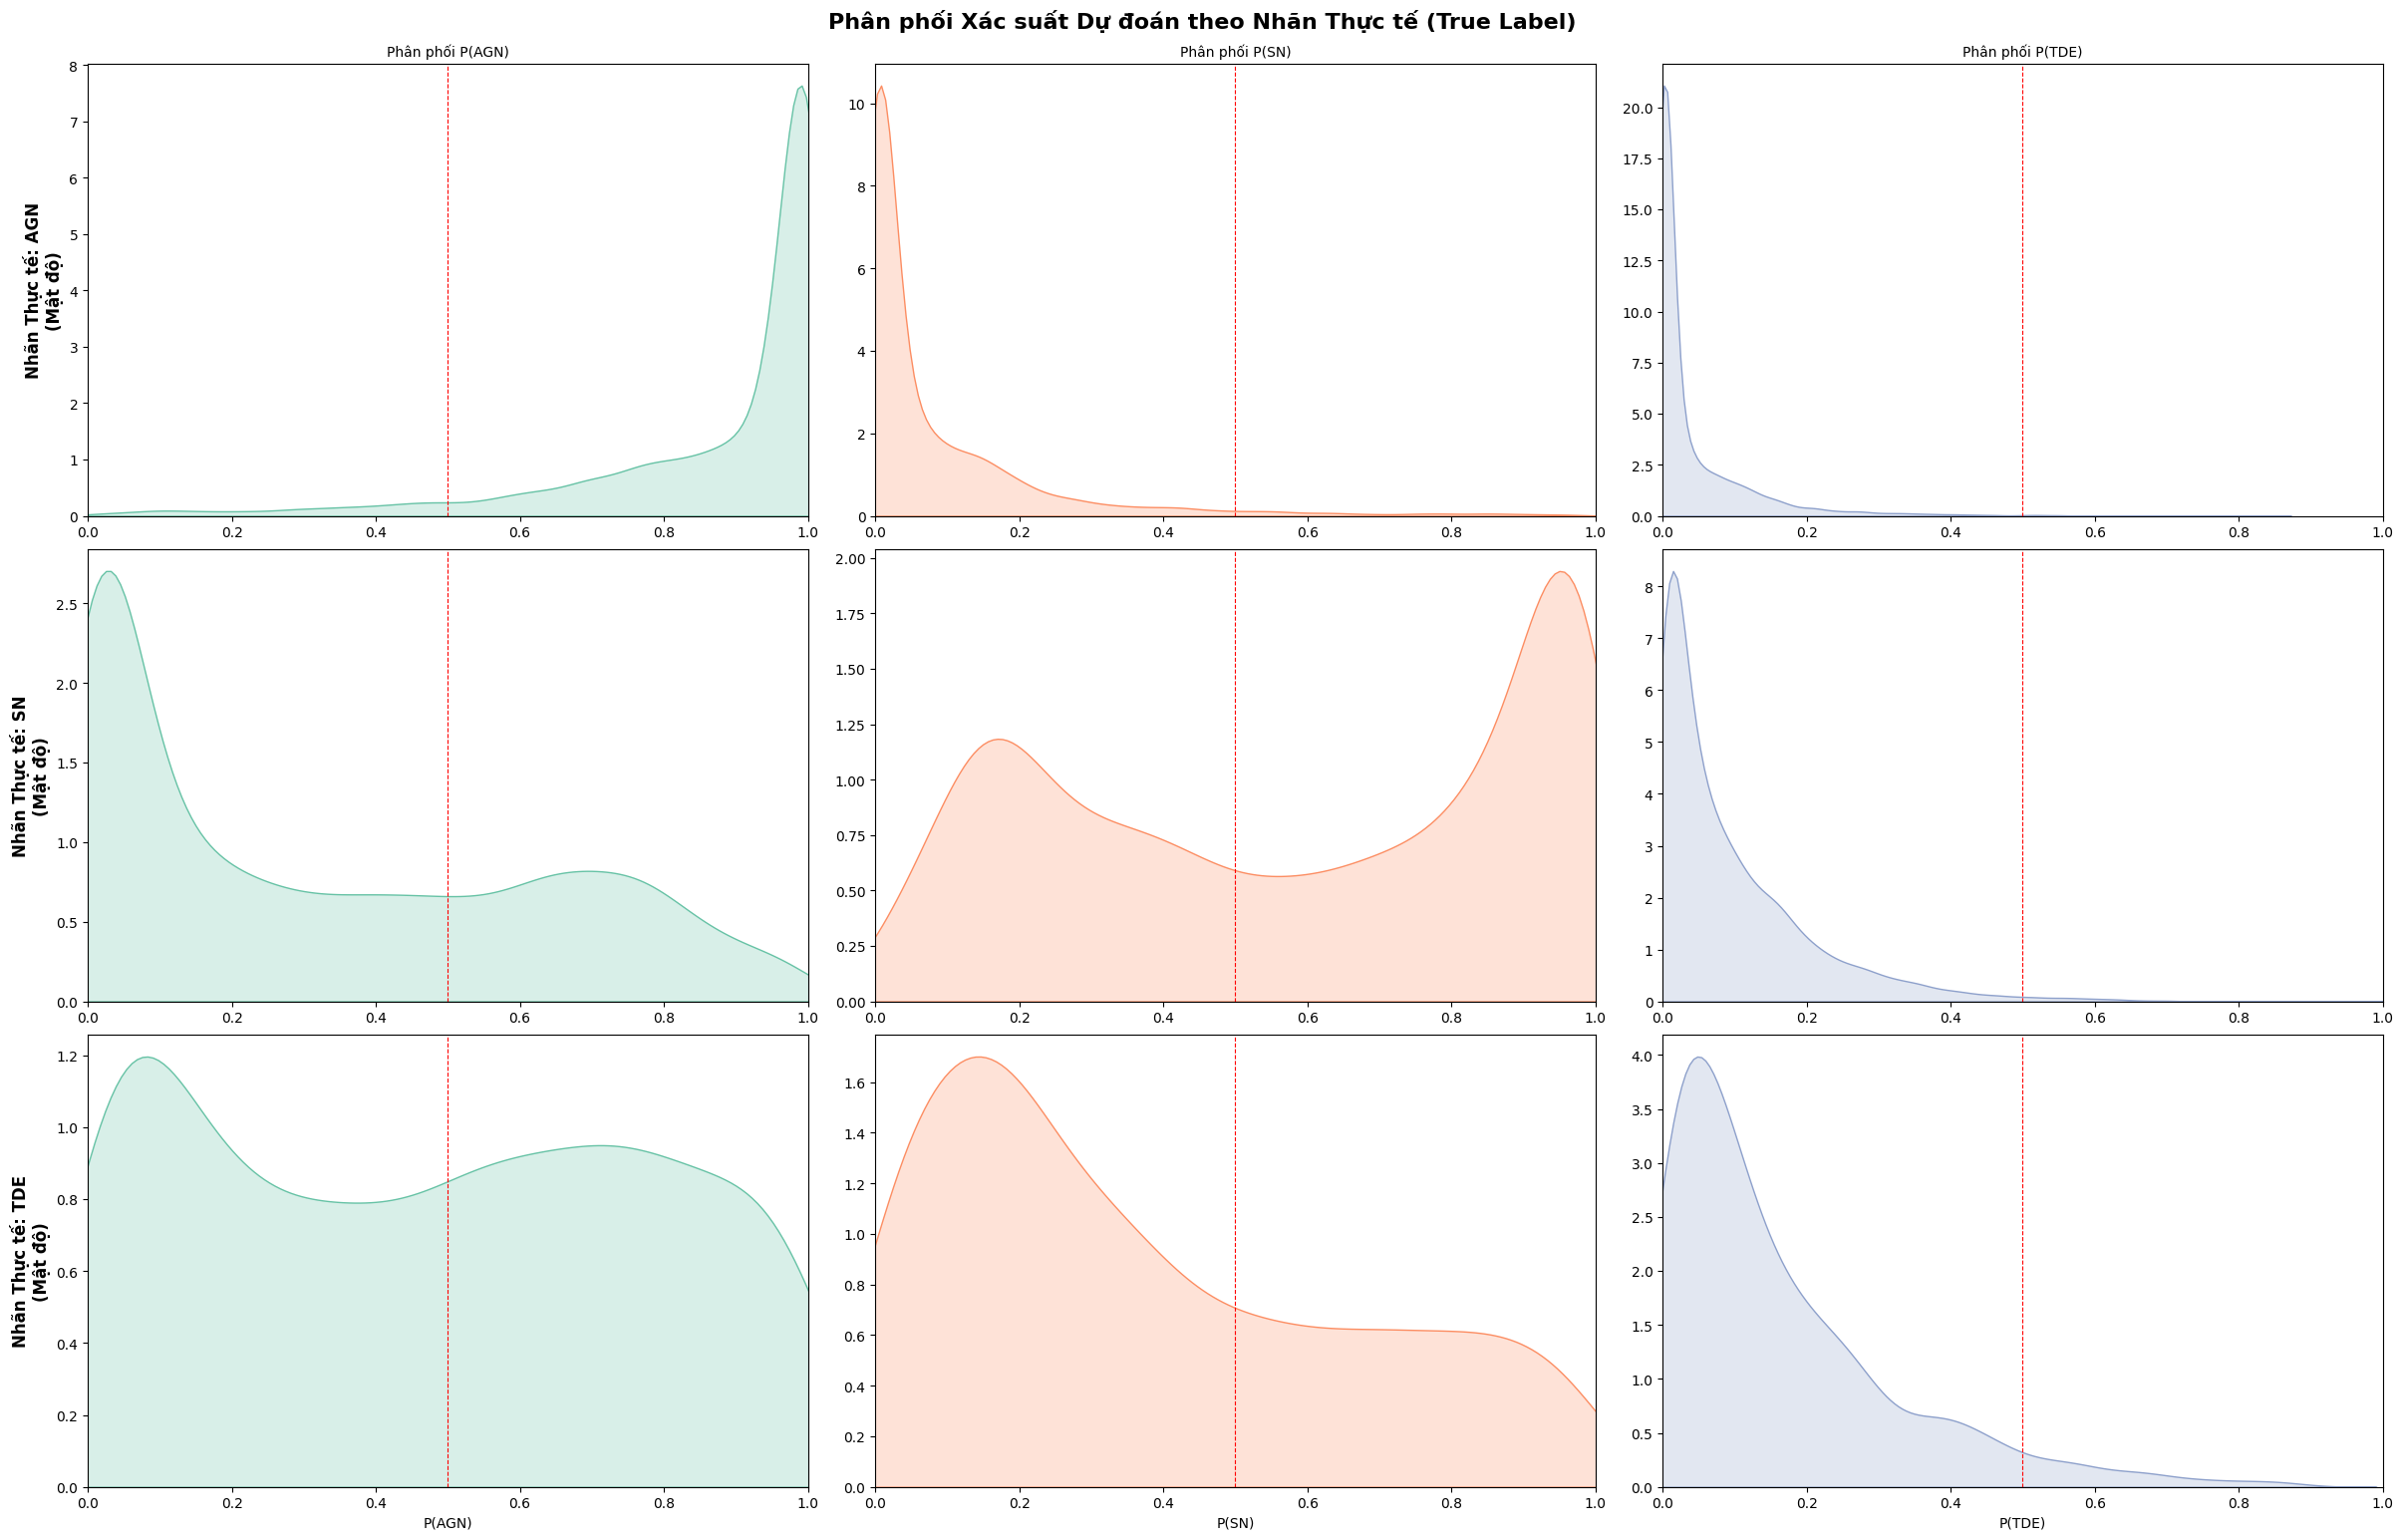

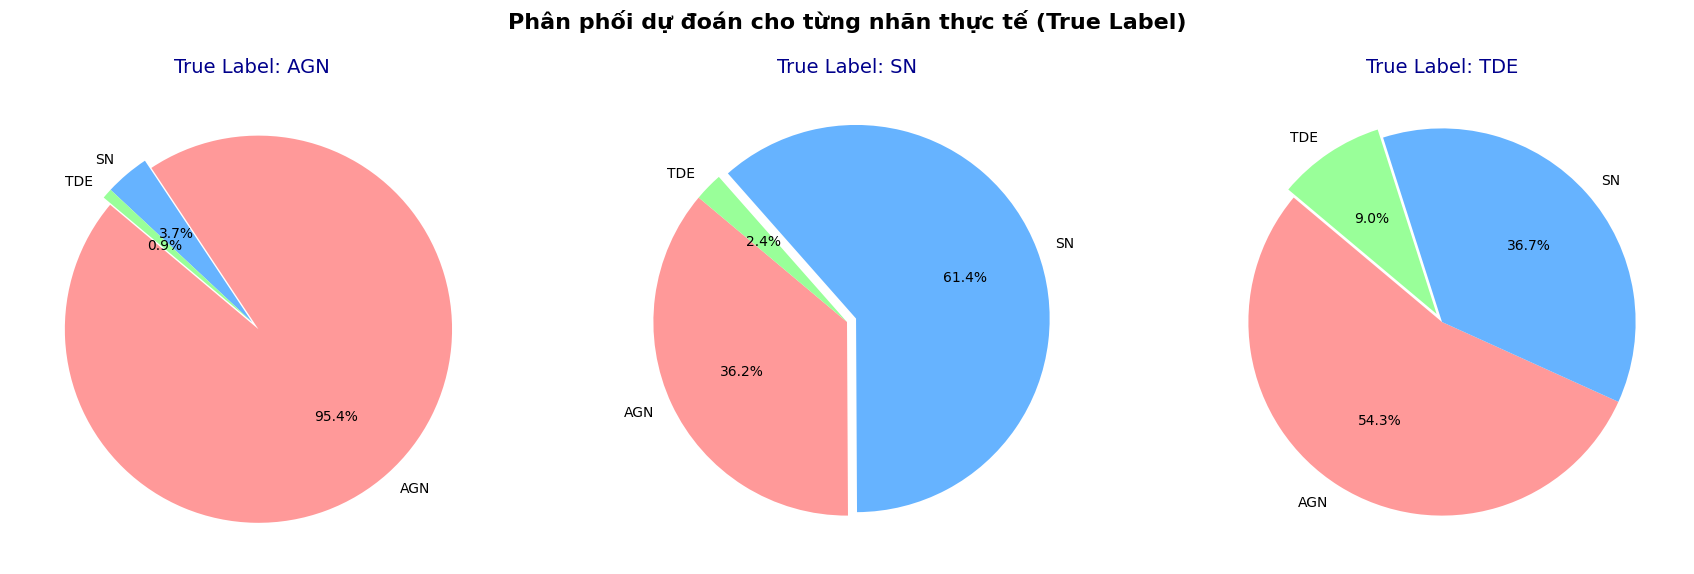

In [41]:
dist = plot_probability_distributions(oof_proba, y_cv, CLASS_NAMES)
plot_prediction_confusion_pie(dist)

In [43]:
selector = ( (dist['AGN'] > 0.5) | (dist['SN'] > 0.5) | (dist['TDE'] > 0.5) ) & ( dist['True Label'] == 'TDE')

dist[selector].iloc[0:50]

,AGN,SN,TDE,Prediction,True Label
object_id,,,,,
amon_imloth_luin,0.739271,0.248445,0.012285,AGN,TDE
amon_imloth_luin,0.024576,0.865449,0.109975,SN,TDE
amon_imloth_luin,0.136306,0.767075,0.096619,SN,TDE
amon_imloth_luin,0.002559,0.992173,0.005269,SN,TDE
amon_imloth_luin,0.357766,0.609835,0.032399,SN,TDE
amon_imloth_luin,0.686984,0.160859,0.152157,AGN,TDE
amon_imloth_luin,0.665204,0.300478,0.034318,AGN,TDE
drafn_araf_ryn,0.726768,0.219137,0.054095,AGN,TDE
drafn_araf_ryn,0.004281,0.933357,0.062362,SN,TDE


# 5. <a id='toc5_'></a>[Xuất](#toc0_)